In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path directory for the dataset
data_dir = '/content/drive/MyDrive/DR'
train_dir = '/content/drive/MyDrive/DR/Train'
test_dir = '/content/drive/MyDrive/DR/Test'
valid_dir = '/content/drive/MyDrive/DR/Valid'

# Augmentation of the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Train the model
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')

# Load InceptionV3 pre-trained on ImageNet without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom top layers with SELU activation
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = Activation('selu')(x)  # Using SELU activation
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
optimizer = Adam(lr=0.00001)  # Adjust the learning rate as needed

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model summary
model.summary()

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping



epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)




Mounted at /content/drive
Found 1750 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
87910968/87910968 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

Found 250 images belonging to 5 classes.
8/8 [==============================] - 79s 10s/step
Accuracy: 0.512
Precision: 0.6183392949849965
Recall: 0.512
F1 Score: 0.5256849625912527
Confusion Matrix:
[[22  8 19  0  1]
 [ 8 13 28  1  0]
 [ 1  6 37  5  1]
 [ 0  1 18 29  2]
 [ 1  0 19  3 27]]


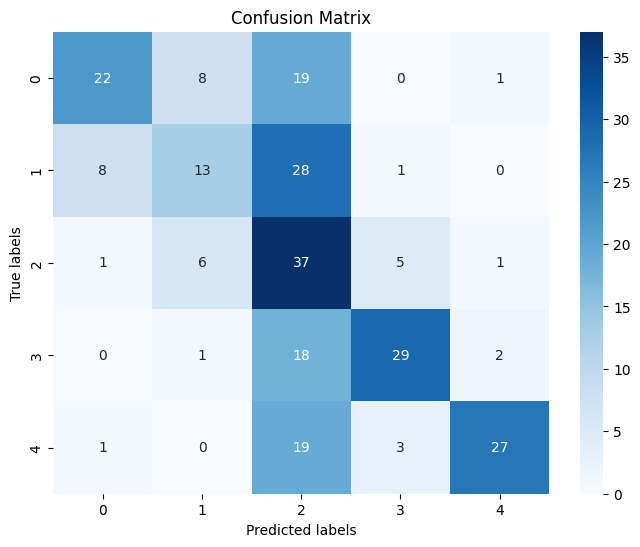

In [3]:
# Calculate performance metrics
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Predict classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)

# True classes
true_classes = test_generator.classes

# Performance metrics
accuracy = accuracy_score(true_classes, y_pred_classes)
precision = precision_score(true_classes, y_pred_classes, average='weighted')
recall = recall_score(true_classes, y_pred_classes, average='weighted')
f1 = f1_score(true_classes, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
